In [1]:
# !pip install tensorflow==2.8.0
#or
# !pip install tensorflow-gpu==2.8.0
# import tensorflow as tf

# !pip install tensorflow-io==0.25.0

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install tensorflow_io 
# !pip install audb
# !pip install audiofile
# !pip install opensmile

In [4]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow_io import audio
import csv

import librosa
from scipy.io import wavfile
from IPython.display import Audio

from glob import glob
import random
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
import scipy

import os
import time

import numpy as np
import pandas as pd

import audb
import audiofile
import opensmile



In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.MirroredStrategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
REPLICAS:  1


In [6]:
path = r"C:\Users\bapti\KTH\clip_wav"
test_path = r"C:\Users\bapti\KTH\clip_wav\test"
valid_path = r"C:\Users\bapti\KTH\clip_wav\validation"
train_path = r"C:\Users\bapti\KTH\clip_wav\train"

labels_path = r"C:\Users\bapti\KTH\PodcastFillers.csv"
checkpoint_filepath = r"C:\Users\bapti\KTH\checkpoints\checkpoint"

In [7]:
test_files = os.listdir(path = test_path)
train_files = os.listdir(path =  train_path)
valid_files = os.listdir(path =  valid_path)

In [8]:
# !pip install audb --user

In [9]:
# !pip install opensmile --user

In [10]:

db = audb.load(
    'emodb',
    version='1.1.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    media='wav/03a01.*',  # load subset
    full_path=False,
    verbose=False,
)
# Process signal
# Read first ten seconds of a file into memory.

file = os.path.join(db.root, db.files[0])
signal, sampling_rate = audiofile.read(
    file,
    duration=10,
    always_2d=True,
)
# We set up a feature extractor for functionals of a pre-defined feature set.

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
# smile.feature_names

In [11]:
sample_rate,wav_data = wavfile.read(test_path + "/"[0] + test_files[0])

In [12]:
sample_rate

16000

In [13]:
import tensorflow.audio
factor = 16*2
batch_size = 32*factor

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [14]:
def dataloader(path, labels_path,desired_sample_rate=16000):
    @tf.function
    def lecture_intern(filename, filepath):
        """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
        file_contents = tf.io.read_file(filepath + "/"[0] +filename)
        wav, sample_rate = tf.audio.decode_wav(
                      file_contents,
              desired_channels=1)
        wav = tf.squeeze(wav, axis=-1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=desired_sample_rate)
        return wav/tf.int16.max
    

    # def lecture_intern(filename, filepath):
    #     sample_rate, wav_data = wavfile.read(filepath + "/"[0] + filename, 'rb')
    #     # print("SAMPLE RATE : ", sample_rate)
    #     # print("WAV_DATA : ", wav_data)
    #     wav_data = ensure_sample_rate(sample_rate, wav_data,desired_sample_rate)
    #     return wav_data/tf.int16.max

    # def lecture_intern(filename, filepath):
    #     wav, sample_rate = librosa.load(filepath+"/"[0]+filename,sr = desired_sample_rate)
    #     return wav/tf.int16.max

    @tf.function
    def extract_embedding(wav_data):
      ''' run YAMNet to extract embedding from the wav data '''
      wav_data = tf.convert_to_tensor(wav_data)
      scores, embeddings, spectrogram = yamnet_model(wav_data)
#       num_embeddings = tf.shape(embeddings)[0]
      return tf.reshape(embeddings,[1,2048])


    def smile_intern(file):
        return smile(file, desired_sample_rate).reshape((1,88))

#     def ensure_sample_rate(original_sample_rate, waveform,
#                            desired_sample_rate=desired_sample_rate):
#           #Resample waveform if required.
#         if original_sample_rate != desired_sample_rate:
#             desired_length = int(round(float(len(waveform)) /original_sample_rate * desired_sample_rate))
#             waveform = scipy.signal.resample(waveform, desired_length)
#         return waveform
      
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1024)
        ds = ds.batch(batch_size=batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    
    # test_path = test_path
    # valid_path = valid_path
    # train_path = train_path
    
    df_labels = pd.read_csv(labels_path)[["clip_name","label_full_vocab", "confidence", "clip_split_subset"]].head(100)
    # print(df_labels)
    Y = df_labels["label_full_vocab"]
    oe = OrdinalEncoder()
    target = oe.fit_transform(Y.values.reshape(-1, 1)).ravel()
    labels = tf.keras.utils.to_categorical(target, num_classes=13)
    
    y_test_ds = tf.data.Dataset.from_tensor_slices(labels[df_labels["clip_split_subset"] == "test"])
    y_valid_ds = tf.data.Dataset.from_tensor_slices(labels[df_labels["clip_split_subset"] == "validation"])
    y_train_ds = tf.data.Dataset.from_tensor_slices(labels[df_labels["clip_split_subset"] == "train"])
    
    filenames_test = list(df_labels[df_labels["clip_split_subset"] == "test"]["clip_name"])
    filenames_valid = list(df_labels[df_labels["clip_split_subset"] == "validation"]["clip_name"])
    filenames_train = list(df_labels[df_labels["clip_split_subset"] == "train"]["clip_name"])
    
    def lecture_intern_test(file):
        return lecture_intern(file,test_path)
    
    def lecture_intern_valid(file):
        return lecture_intern(file,valid_path)
    
    def lecture_intern_train(file):
        return lecture_intern(file,train_path)

    #.map(reformulate, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # a = time.time()
    # print("test_map")
    # x_test_map = list(map(lecture_intern_test,filenames_test))
    # b = time.time()
    # print("Done in :",b-a, "s")
    # print("test_smile_map")
    # x_test_smile_map = list(map(smile_intern, x_test_map))
    # a = time.time()
    # print("Done in :",a-b, "s")
    # print("test_ds")
    # x_test_ds = tf.data.Dataset.from_tensor_slices(x_test_map).map(extract_embedding, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # b = time.time()
    # print("Done in :",b-a, "s")
    # print("test_smile_ds")
    # x_test_smile_ds = tf.data.Dataset.from_tensor_slices(x_test_smile_map)
    # a = time.time()
    # print("Done in :",a-b, "s":)


    x_test_map = list(map(lecture_intern_test,filenames_test))
    x_test_smile_map = list(map(smile_intern, x_test_map))
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test_map).map(extract_embedding, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    x_test_smile_ds = tf.data.Dataset.from_tensor_slices(x_test_smile_map)

    x_valid_map = list(map(lecture_intern_valid,filenames_valid))
    x_valid_smile_map = list(map(smile_intern, x_valid_map))
    x_valid_ds = tf.data.Dataset.from_tensor_slices(x_valid_map).map(extract_embedding, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    x_valid_smile_ds = tf.data.Dataset.from_tensor_slices(x_valid_smile_map)
    
    x_train_map = list(map(lecture_intern_train,filenames_train))
    x_train_smile_map = list(map(smile_intern, x_train_map))
    x_train_ds = tf.data.Dataset.from_tensor_slices(x_train_map).map(extract_embedding, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    x_train_smile_ds = tf.data.Dataset.from_tensor_slices(x_train_smile_map)

    ds1_test = tf.data.Dataset.zip((x_test_ds, x_test_smile_ds))
    ds_test = tf.data.Dataset.zip((ds1_test, y_test_ds))
    ds_test = configure_for_performance(ds_test)

    # ds_test = tf.data.Dataset.zip((x_test_ds, y_test_ds))
    # ds_test = configure_for_performance(ds_test)
    
    ds1_valid = tf.data.Dataset.zip((x_valid_ds, x_valid_smile_ds))
    ds_valid = tf.data.Dataset.zip((ds1_valid, y_valid_ds))
    ds_valid = configure_for_performance(ds_valid)
    
    ds1_train = tf.data.Dataset.zip((x_train_ds, x_train_smile_ds))
    ds_train = tf.data.Dataset.zip((ds1_train, y_train_ds))
    ds_train = configure_for_performance(ds_train)
    
    # return  ds_test
    
    return ds_train, ds_valid, ds_test

In [15]:
ds_train, ds_valid, ds_test = dataloader(path, labels_path)
# ds_test

In [16]:
# def ensure_sample_rate(original_sample_rate, waveform,
#                        desired_sample_rate=16000):
#     #Resample waveform if required.
#     if original_sample_rate != desired_sample_rate:
#         desired_length = int(round(float(len(waveform)) /original_sample_rate * desired_sample_rate))
#         waveform = scipy.signal.resample(waveform, desired_length)
#     return waveform

In [17]:
# sample_rate,wav_data = wavfile.read(test_path + "/"[0] + test_files[0])
# wav_data = ensure_sample_rate(sample_rate, wav_data)/ tf.int16.max
# print(wav_data)
# print(sample_rate)


In [18]:
# score, embedding, spectrogram = yamnet_model(wav_data)

In [19]:
# embedding

In [20]:
# wav_data.shape

In [21]:
# smile_data = smile(wav_data,16000).reshape((88))

In [22]:
# dummy_data = [wav_data, smile_data]

In [33]:
def create_dummy():

    input_yamnet = tf.keras.layers.Input(shape=(2048), dtype=tf.float32, name='audio', ragged = True)
    input_yamnet = tf.reshape(input_yamnet, [-1,1,2048])
#     input_yamnet = tf.keras.layers.BatchNormalization()(input_yamnet)
    input_smile = tf.keras.layers.Input(shape=(88), dtype=tf.float32, name='smile', ragged = True)
    input_smile = tf.reshape(input_smile, [-1,1,88])
    


    concat_layer = tf.keras.layers.Concatenate(axis = 2 )([input_smile , input_yamnet])

    first_layer = tf.keras.layers.Dense(16, activation = "selu")(concat_layer)
    first_layer =  tf.keras.layers.BatchNormalization()(first_layer)
#     first_layer = tf.keras.layers.Dense(1024, activation = "relu")(concat_layer)
#     first_layer =  tf.keras.layers.BatchNormalization()(first_layer)
    
#     first_layer = tf.keras.layers.Dense(512, activation = "relu")(first_layer)
#     first_layer =  tf.keras.layers.BatchNormalization()(first_layer)
#     first_layer = tf.keras.layers.Dense(128, activation = "relu")(first_layer)
#     first_layer =  tf.keras.layers.BatchNormalization()(first_layer)

    output = tf.keras.layers.Dense(13,activation = None, dtype='float32')(first_layer)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Activation("softmax")(output)
    output = tf.reshape(output, [-1,13])
    # output = ReduceMeanLayer(axis=0, name='classifier')(output)
    model = tf.keras.models.Model(inputs=[input_yamnet,input_smile], outputs= output)
    # model = tf.keras.models.Model(inputs=input_segment, outputs= output)
    model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer = "RMSprop")
    return model

dummy_model = create_dummy()

In [24]:
lr_min = 1e-5/factor
lr_max = 1e-2/factor

def my_cosine_decay(epoch,
                    epoch_max=5,
                    LR_START = 0.0001/2,
                    LR_MAX =  lr_max,
                    LR_MIN = lr_min,
                    LR_RAMPUP_EPOCHS = 3,
                    LR_SUSTAIN_EPOCHS = 0,
                    LR_ALPHA_DECAY = .7
                   ):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        cosine_decay=max(0.5*(1+np.cos(np.pi*((epoch-LR_RAMPUP_EPOCHS)/epoch_max))),LR_MIN)
        decayed=(1-LR_ALPHA_DECAY)*cosine_decay+LR_ALPHA_DECAY
        learning_rate=LR_MAX*decayed
    return learning_rate

def lr_decay(epoch,
            LR_START = lr_max/2,
            LR_MAX =  lr_max,
            LR_MIN = lr_min,
            LR_RAMPUP_EPOCHS = 3,
            LR_SUSTAIN_EPOCHS = 0,
            LR_ALPHA_DECAY = .05
                   ):
    learning_rate=max(LR_MAX*np.exp(-LR_ALPHA_DECAY*epoch), LR_MIN)
    return learning_rate
   

def my_clr(epoch,
           epoch_cycle = 8,
           LR_MIN = lr_min,
           LR_MAX = lr_max,
           LR_ALPHA_DECAY = .9):
    nb_cycle = epoch // epoch_cycle
    k=0
    while k < nb_cycle :
        LR_MAX = (LR_MAX+ LR_MIN)*LR_ALPHA_DECAY
        k += 1
    if epoch % epoch_cycle < epoch_cycle//2 :
        learning_rate = (LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MIN
    else :
        learning_rate = -(LR_MAX - LR_MIN) / (epoch_cycle//2) * (epoch % (epoch_cycle//2)) + LR_MAX
    return learning_rate
    
lrfn=lambda epoch : my_clr(
       epoch,
        LR_MIN = lr_min,
        LR_MAX = lr_max
    )


checkpoint_dir = os.path.dirname(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=16,verbose=1)

In [34]:
history = dummy_model.fit(x = ds_test,validation_data = ds_train, validation_steps=int(len(train_files)/batch_size) ,epochs = 1000, callbacks = [lr_callback, early_stopper], steps_per_epoch = int(len(test_files)/batch_size))


Epoch 1: LearningRateScheduler setting learning rate to 6.25e-07.
Epoch 1/1000
18/18 [==============================] - 3s 118ms/step - loss: 2.9017 - accuracy: 0.0000e+00 - val_loss: 12.8566 - val_accuracy: 0.0000e+00 - lr: 6.2500e-07

Epoch 2: LearningRateScheduler setting learning rate to 0.00015671875.
Epoch 2/1000
18/18 [==============================] - 2s 106ms/step - loss: 2.2178 - accuracy: 0.3111 - val_loss: 11.7324 - val_accuracy: 0.0000e+00 - lr: 1.5672e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0003128125.
Epoch 3/1000
18/18 [==============================] - 2s 105ms/step - loss: 1.5778 - accuracy: 0.6778 - val_loss: 12.0811 - val_accuracy: 0.0000e+00 - lr: 3.1281e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00046890625000000003.
Epoch 4/1000
18/18 [==============================] - 1s 86ms/step - loss: 1.4731 - accuracy: 0.8111 - val_loss: 11.7241 - val_accuracy: 0.0000e+00 - lr: 4.6891e-04

Epoch 5: LearningRateScheduler setting le

Epoch 35/1000
18/18 [==============================] - 2s 96ms/step - loss: 0.8244 - accuracy: 1.0000 - val_loss: 16.1181 - val_accuracy: 0.0000e+00 - lr: 2.0631e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.000309153953125.
Epoch 36/1000
18/18 [==============================] - 2s 92ms/step - loss: 0.8203 - accuracy: 1.0000 - val_loss: 16.1181 - val_accuracy: 0.0000e+00 - lr: 3.0915e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0004119969375.
Epoch 37/1000
18/18 [==============================] - 1s 82ms/step - loss: 0.8133 - accuracy: 1.0000 - val_loss: 16.1181 - val_accuracy: 0.0000e+00 - lr: 4.1200e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.000309153953125.
Epoch 38/1000
18/18 [==============================] - 2s 95ms/step - loss: 0.7872 - accuracy: 1.0000 - val_loss: 16.1181 - val_accuracy: 0.0000e+00 - lr: 3.0915e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.00020631096875.
Epoch 39/1000
18/18 [==========

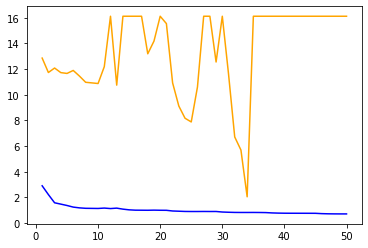

In [35]:

plt.plot(np.arange(1,len(history.history["loss"]) + 1),history.history["loss"], color="blue")
plt.plot(np.arange(1,len(history.history["val_loss"]) + 1),history.history["val_loss"], color="orange")
plt.show()

In [ ]:
dummy_model.evaluate(ds_test,steps=int(len(test_files)/batch_size))

In [ ]:
dummy_model.evaluate(ds_valid,steps=int(len(valid_files)/batch_size))